Best n_components by BIC: 1
Mean Log Likelihood: 13109.067936538046
이상경로

Anomalous Path 6 (File: 20230415140615.csv)
Anomalous Path 39 (File: 20230429074729.csv)
Anomalous Path 41 (File: 20230430160248.csv)
Anomalous Path 42 (File: 20230430184009.csv)
Anomalous Path 51 (File: 20230505122016.csv)
Anomalous Path 54 (File: 20230505150709.csv)
Anomalous Path 58 (File: 20230506175525.csv)
Anomalous Path 59 (File: 20230508084115.csv)
Anomalous Path 96 (File: 20230520133735.csv)
Anomalous Path 97 (File: 20230520140330.csv)
Anomalous Path 115 (File: 20230527205922.csv)
Anomalous Path 116 (File: 20230527221824.csv)
Anomalous Path 173 (File: 20230617213908.csv)
Anomalous Path 185 (File: 20230701212705.csv)
Anomalous Path 186 (File: 20230701220126.csv)
Anomalous Path 199 (File: 20230708184137.csv)
Anomalous Path 201 (File: 20230710075720.csv)
Anomalous Path 215 (File: 20230715124434.csv)
Anomalous Path 216 (File: 20230715132948.csv)
Anomalous Path 217 (File: 20230715154101.csv)
Anomalous Path 22

<Figure size 1000x600 with 0 Axes>

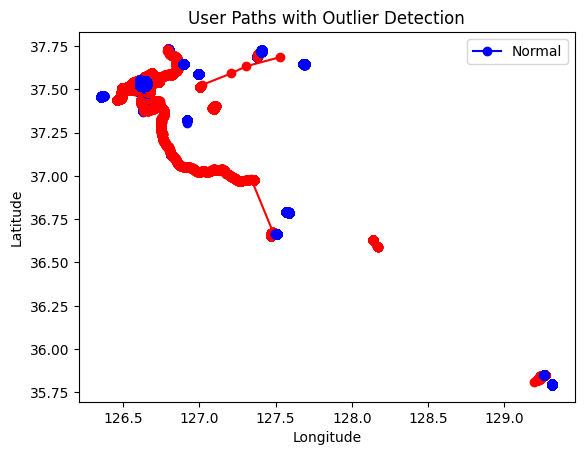

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# CSV 파일에서 경로 데이터를 추출하는 함수 (파일명 포함)
def extract_lat_lng_from_csv(directory):
    all_lat_lng_lists = []
    file_names = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
            all_lat_lng_lists.append(lat_lng_list)
            file_names.append(filename)
    
    return all_lat_lng_lists, file_names

# 경로 데이터를 읽어오는 경로 설정
directory_path = "./어디쉐어/어디쉐어 gmm_NID" 
lat_lng_values, file_names = extract_lat_lng_from_csv(directory_path)

# 가장 긴 경로의 길이를 찾음
max_length = max(len(path) for path in lat_lng_values)

# 모든 경로를 고정된 길이로 패딩 (0 또는 마지막 값 반복으로 패딩)
def pad_path(path, max_length):
    pad_length = max_length - len(path)
    if pad_length > 0:
        last_point = path[-1]  # 마지막 좌표
        path.extend([last_point] * pad_length)  # 마지막 좌표를 pad_length만큼 반복해서 추가
    return np.array(path).flatten()

path_vectors = np.array([pad_path(path, max_length) for path in lat_lng_values])

# 최적의 GMM 파라미터 찾기 (n_components 선택)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 11)
best_gmm = None

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(path_vectors)
    bic.append(gmm.bic(path_vectors))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

# 최적의 n_components 출력
best_n_components = n_components_range[np.argmin(bic)]
print(f"Best n_components by BIC: {best_n_components}")

# 최적의 GMM으로 이상치 탐지 수행
log_likelihoods = best_gmm.score_samples(path_vectors)
mean_log_likelihood = np.mean(log_likelihoods)
print(f"Mean Log Likelihood: {mean_log_likelihood}")






# 이상치 판단
threshold = mean_log_likelihood - 2 * np.std(log_likelihoods)  # 평균 - 2표준편차: 약 95%의 데이터 포인트
outliers = log_likelihoods < threshold

# 각 파일에 'output' 열 기록
def update_csv_with_anomaly_info(directory, file_names, outliers):
    for filename, is_outlier in zip(file_names, outliers):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df['output'] = -1 if is_outlier else 1
        df.to_csv(filepath, index=False)

update_csv_with_anomaly_info(directory_path, file_names, outliers)

# 이상 경로 출력 (파일명 포함)
def print_anomalies(paths, outliers, file_names):
    for i, is_outlier in enumerate(outliers):
        if is_outlier:
            print(f"Anomalous Path {i+1} (File: {file_names[i]})")

print("이상경로\n")
print_anomalies(lat_lng_values, outliers, file_names)



# 시각화

plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
for i, path in enumerate(lat_lng_values):
    latitudes = [point[1] for point in path]
    longitudes = [point[0] for point in path]
    if outliers[i]:
        ax.plot(latitudes, longitudes, 'r', marker='o', label='Outlier' if i == 0 else "")
    else:
        ax.plot(latitudes, longitudes, 'b', marker='o', label='Normal' if i == 0 else "")

# 레이블 추가
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('User Paths with Outlier Detection')
ax.legend()
plt.show()


### 이상치 여부를 원본 CSV 파일에 기록

In [11]:
def update_csv_with_anomaly_info(directory, file_names, outliers):
    for filename, is_outlier in zip(file_names, outliers):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df['output'] = 'AN' if is_outlier else 'N'
        df.to_csv(filepath, index=False)

update_csv_with_anomaly_info(directory_path, file_names, outliers)